# Convolutional Neural Networks

## Project: Write an Algorithm for Landmark Classification

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all the code implementations, you need to finalize your work by exporting the Jupyter Notebook as an HTML document. Before exporting the notebook to HTML, all the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to **File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this Jupyter notebook.

---
### Why We're Here

Photo sharing and photo storage services like to have location data for each photo that is uploaded. With the location data, these services can build advanced features, such as automatic suggestion of relevant tags or automatic photo organization, which help provide a compelling user experience. Although a photo's location can often be obtained by looking at the photo's metadata, many photos uploaded to these services will not have location metadata available. This can happen when, for example, the camera capturing the picture does not have GPS or if a photo's metadata is scrubbed due to privacy concerns.

If no location metadata for an image is available, one way to infer the location is to detect and classify a discernable landmark in the image. Given the large number of landmarks across the world and the immense volume of images that are uploaded to photo sharing services, using human judgement to classify these landmarks would not be feasible.

In this notebook, you will take the first steps towards addressing this problem by building models to automatically predict the location of the image based on any landmarks depicted in the image. At the end of this project, your code will accept any user-supplied image as input and suggest the top k most relevant landmarks from 50 possible landmarks from across the world. The image below displays a potential sample output of your finished project.

![Sample landmark classification output](images/sample_landmark_output.png)


### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Download Datasets and Install Python Modules
* [Step 1](#step1): Create a CNN to Classify Landmarks (from Scratch)
* [Step 2](#step2): Create a CNN to Classify Landmarks (using Transfer Learning)
* [Step 3](#step3): Write Your Landmark Prediction Algorithm

---
<a id='step0'></a>
## Step 0: Download Datasets and Install Python Modules

**Note: if you are using the Udacity workspace, *YOU CAN SKIP THIS STEP*. The dataset can be found in the `/data` folder and all required Python modules have been installed in the workspace.**

Download the [landmark dataset](https://udacity-dlnfd.s3-us-west-1.amazonaws.com/datasets/landmark_images.zip).
Unzip the folder and place it in this project's home directory, at the location `/landmark_images`.

Install the following Python modules:
* cv2
* matplotlib
* numpy
* PIL
* torch
* torchvision

In [28]:
!pip install split_folders
import splitfolders

In [29]:
from PIL import Image
import torch
import torch.nn as nn
from torchvision import datasets
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
from sklearn.model_selection import train_test_split
import os
import numpy as np

---

<a id='step1'></a>
## Step 1: Create a CNN to Classify Landmarks (from Scratch)

In this step, you will create a CNN that classifies landmarks.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 20%.

Although 20% may seem low at first glance, it seems more reasonable after realizing how difficult of a problem this is. Many times, an image that is taken at a landmark captures a fairly mundane image of an animal or plant, like in the following picture.

<img src="images/train/00.Haleakala_National_Park/084c2aa50d0a9249.jpg" alt="Bird in Haleakalā National Park" style="width: 400px;"/>

Just by looking at that image alone, would you have been able to guess that it was taken at the Haleakalā National Park in Hawaii?

An accuracy of 20% is significantly better than random guessing, which would provide an accuracy of just 2%. In Step 2 of this notebook, you will have the opportunity to greatly improve accuracy by using transfer learning to create a CNN.

Remember that practice is far ahead of theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun!

### (IMPLEMENTATION) Specify Data Loaders for the Landmark Dataset

Use the code cell below to create three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader): one for training data, one for validation data, and one for test data. Randomly split the images located at `landmark_images/train` to create the train and validation data loaders, and use the images located at `landmark_images/test` to create the test data loader.

**Note**: Remember that the dataset can be found at `/data/landmark_images/` in the workspace.

All three of your data loaders should be accessible via a dictionary named `loaders_scratch`. Your train data loader should be at `loaders_scratch['train']`, your validation data loader should be at `loaders_scratch['valid']`, and your test data loader should be at `loaders_scratch['test']`.

You may find [this documentation on custom datasets](https://pytorch.org/docs/stable/torchvision/datasets.html#datasetfolder) to be a useful resource.  If you are interested in augmenting your training and/or validation data, check out the wide variety of [transforms](http://pytorch.org/docs/stable/torchvision/transforms.html?highlight=transform)!

In [30]:
output = splitfolders.ratio("/data/landmark_images/train", output="output", seed=1337, ratio=(.8, .2), group_prefix=None)

Copying files: 4996 files [00:12, 393.43 files/s]


In [31]:
### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes
train_dir = '/home/workspace/nd101-c2-landmarks-starter/landmark_project/output/train/'
valid_dir = '/home/workspace/nd101-c2-landmarks-starter/landmark_project/output/val//'
test_dir = '/data/landmark_images/test'

train_transforms = transforms.Compose([transforms.RandomRotation(15),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.RandomVerticalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                          [0.229, 0.224, 0.225])
                                      ])

valid_transforms = transforms.Compose([transforms.Resize(225),
                                       transforms.CenterCrop(224),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                          [0.229, 0.224, 0.225])
                                       ])

test_transforms = transforms.Compose([transforms.Resize(225),
                                       transforms.CenterCrop(224),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                          [0.229, 0.224, 0.225])
                                       ])

batch_size = 64
train_size=0.8

# split train data for training and validation

train_data = datasets.ImageFolder(train_dir, transform=train_transforms)
valid_data = datasets.ImageFolder(valid_dir, transform=valid_transforms)
test_data = datasets.ImageFolder(test_dir, transform=test_transforms)



train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)


loaders_scratch = {'train': train_loader, 'valid': valid_loader, 'test': test_loader}


**Question 1:** Describe your chosen procedure for preprocessing the data. 
- How does your code resize the images (by cropping, stretching, etc)?  What size did you pick for the input tensor, and why?
- Did you decide to augment the dataset?  If so, how (through translations, flips, rotations, etc)?  If not, why not?

**Answer**:

> For Training data I resized the images to be 224*224 using Random Resize Crop transform to randomly crop the photos to train the model with a variety of cropped photos as real-world photos will be randomized photos may the dog be in just a part of the photo.

> For Validation and testing data I resized the photos to 225 then cropped them to 224 to make the model can see the whole photo in the same size to make the prediction. I used 224 sizes because it is a suitable size not big or small.

> I decided to augment the training data set by RandomRotation, RandomHorizontalFlip, and RandomVerticalFlip to train the model on different photos as the real-world phots may be.

> but for the validation and testing data, I didn't augment it because I want to test the model using it not training the model so I decided to leave it as it is, also it is already randomized.

### (IMPLEMENTATION) Visualize a Batch of Training Data

Use the code cell below to retrieve a batch of images from your train data loader, display at least 5 images simultaneously, and label each displayed image with its class name (e.g., "Golden Gate Bridge").

Visualizing the output of your data loader is a great way to ensure that your data loading and preprocessing are working as expected.

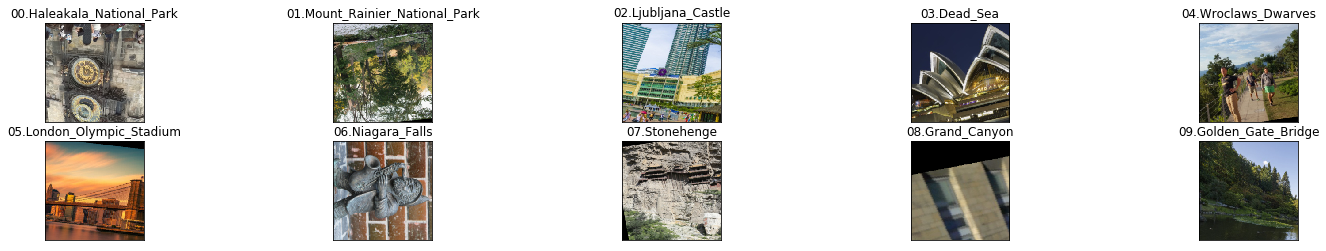

In [32]:
import matplotlib.pyplot as plt
%matplotlib inline

## TODO: visualize a batch of the train data loader

## the class names can be accessed at the `classes` attribute
## of your dataset object (e.g., `train_dataset.classes`)
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
plot_size=10
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    image = images[idx].numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    image = np.clip(image, 0, 1)
    ax.imshow(image)
    # print out the correct label for each image
    # .item() gets the value contained in a Tensor
    ax.set_title(str(train_loader.dataset.classes[idx]))

### Initialize use_cuda variable

In [33]:
# useful variable that tells us whether we should use the GPU
use_cuda = torch.cuda.is_available()

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_scratch`, and fill in the function `get_optimizer_scratch` below.

In [40]:
import torch.optim as optim

## TODO: select loss function
criterion_scratch = nn.CrossEntropyLoss()

def get_optimizer_scratch(model):
    ## TODO: select and return an optimizer
    optimizer_scratch = torch.optim.Adam(model.parameters(), lr=0.0005)
    return optimizer_scratch

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify images of landmarks.  Use the template in the code cell below.

In [35]:
import torch.nn as nn

# define the CNN architecture
class Net(nn.Module):
    ## TODO: choose an architecture, and complete the class
    def __init__(self):
        super(Net, self).__init__()
        
        ## Define layers of a CNN
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv4 = nn.Conv2d(128, 256, 3, padding=1)
        self.conv5 = nn.Conv2d(256, 512, 3, padding=1)
        self.conv6 = nn.Conv2d(512,512, 3, padding=1)
        
        self.conv1_bn=nn.BatchNorm2d(32)
        self.conv2_bn=nn.BatchNorm2d(64)
        self.conv3_bn=nn.BatchNorm2d(128)
        self.conv4_bn=nn.BatchNorm2d(256)
        self.conv5_bn=nn.BatchNorm2d(512)

        # Define Linear layer
        self.fc1 = nn.Linear(512 * 7 * 7, 2048)
        self.fc2 = nn.Linear(2048, 1024)
        self.fc3 = nn.Linear(1024, 133)
        
        # Define pool layer and dropout
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.2)
        
        
    
    def forward(self, x):
        ## Define forward behavior
        x = self.pool(F.relu(self.conv1(x)))
        x = self.conv1_bn(x)
        x = self.pool(F.relu(self.conv2(x)))
        x = self.conv2_bn(x)
        x = self.pool(F.relu(self.conv3(x)))
        x = self.conv3_bn(x)
        x = self.pool(F.relu(self.conv4(x)))
        x = self.conv4_bn(x)
        x = self.pool(F.relu(self.conv5(x)))
        x = self.conv5_bn(x)
        x = F.relu(self.conv6(x))
       # print(x.shape)
        x = x.view(-1, 512 * 7 * 7)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.fc3(x)
       # x = F.log_softmax(x,dim=1)
        return x
    
#-#-# Do NOT modify the code below this line. #-#-#

# instantiate the CNN
model_scratch = Net()

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()

__Question 2:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  

__Answer:__ 

- Starting with Conv2d layer take 3 input for RGB (a layer for every color) and output 32

- and so on until the fifth and last conv2d layer takes 256 input and output 512

- between every two convolotional layers we use a maxpool layer sized (2, 2) to decrase the spatial by half.

- After asking and make some researching I used BatchNorm layer after every maxPool layer, before using it the valid loss didn't decrease.
 
- then I used x.view(-1, 512 * 7 * 7) to flaten the output of the last conv layer to input it ot a linear layer, I printed x.shape to make sure 512 * 7 * 7 is the true shape of flaten
 
- then I used  a three linear layers to train the model in the final part of the network.
 
- the last linear layer has 133 output nodes because we have 133 dog breeds.
 
- I used dropout(0.2) to prevent over fitting on linear layers(except the out layer)
 
- I used relu activation function on all layers (conv and linear) except the out layer I didn't use any activation funciton

### (IMPLEMENTATION) Implement the Training Algorithm

Implement your training algorithm in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at the filepath stored in the variable `save_path`.

In [36]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        # set the module to training mode
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()

            ## TODO: find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - train_loss))
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            train_loss += ((1 / (batch_idx + 1)) * (loss.data - train_loss))
           
            

        ######################    
        # validate the model #
        ######################
        # set the model to evaluation mode
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()

            ## TODO: update average validation loss 
            output = model(data)
            loss = criterion(output, target)
            valid_loss += ((1 / (batch_idx + 1)) * (loss.data - valid_loss))
           
            

        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))

        ## TODO: if the validation loss has decreased, save the model at the filepath stored in save_path
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min, valid_loss))
            torch.save(model_scratch.state_dict(), save_path)
            valid_loss_min = valid_loss    
   
        
    return model

### (IMPLEMENTATION) Experiment with the Weight Initialization

Use the code cell below to define a custom weight initialization, and then train with your weight initialization for a few epochs. Make sure that neither the training loss nor validation loss is `nan`.

Later on, you will be able to see how this compares to training with PyTorch's default weight initialization.

In [37]:
def custom_weight_init(m):
    ## TODO: implement a weight initialization strategy
    
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    
    

#-#-# Do NOT modify the code below this line. #-#-#
    
model_scratch.apply(custom_weight_init)
model_scratch = train(20, loaders_scratch, model_scratch, get_optimizer_scratch(model_scratch),
                      criterion_scratch, use_cuda, 'ignore.pt')

Epoch: 1 	Training Loss: 11.327393 	Validation Loss: 3.934231
Validation loss decreased (inf --> 3.934231).  Saving model ...
Epoch: 2 	Training Loss: 3.932759 	Validation Loss: 3.917609
Validation loss decreased (3.934231 --> 3.917609).  Saving model ...
Epoch: 3 	Training Loss: 3.926396 	Validation Loss: 3.916487
Validation loss decreased (3.917609 --> 3.916487).  Saving model ...
Epoch: 4 	Training Loss: 3.925100 	Validation Loss: 3.916389
Validation loss decreased (3.916487 --> 3.916389).  Saving model ...
Epoch: 5 	Training Loss: 3.923787 	Validation Loss: 3.915707
Validation loss decreased (3.916389 --> 3.915707).  Saving model ...
Epoch: 6 	Training Loss: 3.925708 	Validation Loss: 3.915038
Validation loss decreased (3.915707 --> 3.915038).  Saving model ...
Epoch: 7 	Training Loss: 10.966455 	Validation Loss: 8.406179
Epoch: 8 	Training Loss: 4.297956 	Validation Loss: 3.916720
Epoch: 9 	Training Loss: 3.922575 	Validation Loss: 3.915947
Epoch: 10 	Training Loss: 21.976776 	Val

### (IMPLEMENTATION) Train and Validate the Model

Run the next code cell to train your model.

In [ ]:
# load model to continue traing not began from scratch every time:
model_scratch.load_state_dict(torch.load('model_scratch.pt'))

In [41]:
## TODO: you may change the number of epochs if you'd like,
## but changing it is not required
num_epochs = 100

#-#-# Do NOT modify the code below this line. #-#-#

# function to re-initialize a model with pytorch's default weight initialization
def default_weight_init(m):
    reset_parameters = getattr(m, 'reset_parameters', None)
    if callable(reset_parameters):
        m.reset_parameters()

# reset the model parameters
model_scratch.apply(default_weight_init)

# train the model
model_scratch = train(num_epochs, loaders_scratch, model_scratch, get_optimizer_scratch(model_scratch), 
                      criterion_scratch, use_cuda, 'model_scratch.pt')

Epoch: 1 	Training Loss: 3.940481 	Validation Loss: 3.590591
Validation loss decreased (inf --> 3.590591).  Saving model ...
Epoch: 2 	Training Loss: 3.625323 	Validation Loss: 3.489950
Validation loss decreased (3.590591 --> 3.489950).  Saving model ...
Epoch: 3 	Training Loss: 3.489445 	Validation Loss: 3.334793
Validation loss decreased (3.489950 --> 3.334793).  Saving model ...
Epoch: 4 	Training Loss: 3.401591 	Validation Loss: 3.205499
Validation loss decreased (3.334793 --> 3.205499).  Saving model ...
Epoch: 5 	Training Loss: 3.261040 	Validation Loss: 3.141026
Validation loss decreased (3.205499 --> 3.141026).  Saving model ...
Epoch: 6 	Training Loss: 3.176609 	Validation Loss: 2.992137
Validation loss decreased (3.141026 --> 2.992137).  Saving model ...
Epoch: 7 	Training Loss: 3.093786 	Validation Loss: 2.978794
Validation loss decreased (2.992137 --> 2.978794).  Saving model ...
Epoch: 8 	Training Loss: 3.029155 	Validation Loss: 2.814390
Validation loss decreased (2.97879

### (IMPLEMENTATION) Test the Model

Run the code cell below to try out your model on the test dataset of landmark images. Run the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 20%.

In [42]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    # set the module to evaluation mode
    model.eval()

    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('model_scratch.pt'))
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

Test Loss: 1.798603


Test Accuracy: 58% (732/1250)


---
<a id='step2'></a>
## Step 2: Create a CNN to Classify Landmarks (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify landmarks from images.  Your CNN must attain at least 60% accuracy on the test set.

### (IMPLEMENTATION) Specify Data Loaders for the Landmark Dataset

Use the code cell below to create three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader): one for training data, one for validation data, and one for test data. Randomly split the images located at `landmark_images/train` to create the train and validation data loaders, and use the images located at `landmark_images/test` to create the test data loader.

All three of your data loaders should be accessible via a dictionary named `loaders_transfer`. Your train data loader should be at `loaders_transfer['train']`, your validation data loader should be at `loaders_transfer['valid']`, and your test data loader should be at `loaders_transfer['test']`.

If you like, **you are welcome to use the same data loaders from the previous step**, when you created a CNN from scratch.

In [43]:
### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes

### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes
train_dir = '/home/workspace/nd101-c2-landmarks-starter/landmark_project/output/train/'
valid_dir = '/home/workspace/nd101-c2-landmarks-starter/landmark_project/output/val//'
test_dir = '/data/landmark_images/test'

train_transforms = transforms.Compose([transforms.RandomRotation(15),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.RandomVerticalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                          [0.229, 0.224, 0.225])
                                      ])

valid_transforms = transforms.Compose([transforms.Resize(225),
                                       transforms.CenterCrop(224),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                          [0.229, 0.224, 0.225])
                                       ])

test_transforms = transforms.Compose([transforms.Resize(225),
                                       transforms.CenterCrop(224),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                          [0.229, 0.224, 0.225])
                                       ])

batch_size = 64
train_size=0.8

# split train data for training and validation

train_data = datasets.ImageFolder(train_dir, transform=train_transforms)
valid_data = datasets.ImageFolder(valid_dir, transform=valid_transforms)
test_data = datasets.ImageFolder(test_dir, transform=test_transforms)



train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)


loaders_transfer = {'train': train_loader, 'valid': valid_loader, 'test': test_loader}


### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_transfer`, and fill in the function `get_optimizer_transfer` below.

In [44]:
## TODO: select loss function
criterion_transfer = nn.CrossEntropyLoss()


def get_optimizer_transfer(model):
    ## TODO: select and return optimizer
    optimizer_transfer = torch.optim.Adam(model.classifier.parameters(), lr=0.0001)
    return optimizer_transfer
    
    

### (IMPLEMENTATION) Model Architecture

Use transfer learning to create a CNN to classify images of landmarks.  Use the code cell below, and save your initialized model as the variable `model_transfer`.

In [45]:
## TODO: Specify model architecture
import torchvision.models as models

model_transfer = models.vgg16(pretrained=True)




#-#-# Do NOT modify the code below this line. #-#-#

if use_cuda:
    model_transfer = model_transfer.cuda()

In [46]:
model_transfer.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace)
  (2): Dropout(p=0.5)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace)
  (5): Dropout(p=0.5)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)

In [47]:
# Freeze training for all "features" layers

for param in model_transfer.features.parameters():
    param.requires_grad = False
    
    # change last layer of the model:
model_transfer.classifier[6] = nn.Linear(4096, 133)

__Question 3:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__ 

- Starting with Conv2d layer take 3 input for RGB (a layer for every color) and output 32

- and so on until the fifth and last conv2d layer takes 256 input and output 512

- between every two convolotional layers we use a maxpool layer sized (2, 2) to decrase the spatial by half.

- After asking and make some researching I used BatchNorm layer after every maxPool layer, before using it the valid loss didn't decrease.
 
- then I used x.view(-1, 512 * 7 * 7) to flaten the output of the last conv layer to input it ot a linear layer, I printed x.shape to make sure 512 * 7 * 7 is the true shape of flaten
 
- then I used  a three linear layers to train the model in the final part of the network.
 
- the last linear layer has 133 output nodes because we have 133 dog breeds.
 
- I used dropout(0.2) to prevent over fitting on linear layers(except the out layer)
 
- I used relu activation function on all layers (conv and linear) except the out layer I didn't use any activation funciton

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_transfer.pt'`.

In [48]:
# TODO: train the model and save the best model parameters at filepath 'model_transfer.pt'
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    valid_loss_min = np.Inf
    
    for epoch in range(1, n_epochs+1):
        train_loss = 0
        valid_loss = 0
        ######################    
        # train the model #
        ######################
        model.train()
        for batch_i, (data, target) in enumerate(loaders['train']):
            if use_cuda:
                data, target = data.cuda(), target.cuda()
                model = model.cuda()
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        ######################    
        # validate the model #
        ######################    
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## update the average validation loss
            output = model(data)
            loss = criterion(output, target)
            valid_loss += loss.item()      
            
        #train_loss = train_loss/len(train_loader.dataset)
        #valid_loss = valid_loss/len(valid_loader.dataset)
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(epoch, train_loss, valid_loss))
        
              ## TODO: save the model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min, valid_loss))
            torch.save(model_transfer.state_dict(), save_path)
            valid_loss_min = valid_loss 
    return model        


model_transfer =  train(10, loaders_transfer, model_transfer, get_optimizer_transfer(model_transfer), criterion_transfer, use_cuda, 'model_transfer.pt')

#-#-# Do NOT modify the code below this line. #-#-#

# load the model that got the best validation accuracy
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

Epoch: 1 	Training Loss: 192.269251 	Validation Loss: 24.579182
Validation loss decreased (inf --> 24.579182).  Saving model ...
Epoch: 2 	Training Loss: 119.141470 	Validation Loss: 19.934968
Validation loss decreased (24.579182 --> 19.934968).  Saving model ...
Epoch: 3 	Training Loss: 103.459347 	Validation Loss: 18.183872
Validation loss decreased (19.934968 --> 18.183872).  Saving model ...
Epoch: 4 	Training Loss: 93.636347 	Validation Loss: 17.901281
Validation loss decreased (18.183872 --> 17.901281).  Saving model ...
Epoch: 5 	Training Loss: 86.034404 	Validation Loss: 16.750112
Validation loss decreased (17.901281 --> 16.750112).  Saving model ...
Epoch: 6 	Training Loss: 78.846821 	Validation Loss: 16.100894
Validation loss decreased (16.750112 --> 16.100894).  Saving model ...
Epoch: 7 	Training Loss: 75.112259 	Validation Loss: 16.093006
Validation loss decreased (16.100894 --> 16.093006).  Saving model ...
Epoch: 8 	Training Loss: 69.642188 	Validation Loss: 15.255565
Va

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of landmark images. Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 60%.

In [49]:
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 0.830714


Test Accuracy: 77% (973/1250)


---
<a id='step3'></a>
## Step 3: Write Your Landmark Prediction Algorithm

Great job creating your CNN models! Now that you have put in all the hard work of creating accurate classifiers, let's define some functions to make it easy for others to use your classifiers.

### (IMPLEMENTATION) Write Your Algorithm, Part 1

Implement the function `predict_landmarks`, which accepts a file path to an image and an integer k, and then predicts the **top k most likely landmarks**. You are **required** to use your transfer learned CNN from Step 2 to predict the landmarks.

An example of the expected behavior of `predict_landmarks`:
```
>>> predicted_landmarks = predict_landmarks('example_image.jpg', 3)
>>> print(predicted_landmarks)
['Golden Gate Bridge', 'Brooklyn Bridge', 'Sydney Harbour Bridge']
```

In [137]:
import cv2
from PIL import Image

## the class names can be accessed at the `classes` attribute
## of your dataset object (e.g., `train_dataset.classes`)
class_names = [item[3:].replace("_", " ") for item in train_data.classes]
def predict_landmarks(img_path, k):
    ## TODO: return the names of the top k landmarks predicted by the transfer learned CNN
    im = Image.open(img_path).convert('RGB')
    transform = transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406),
                             (0.229, 0.224, 0.225))])
    im = transform(im)
    im = im.unsqueeze(0)
    im = Variable(im)
    if use_cuda:
        im = im.cuda()
    model_transfer.eval()
    output = model_transfer(im)
    
    _top_v, top_i = torch.topk(output, k, largest=True, sorted=True)
    predictions = top_i[0].tolist()
    landmarks =[]
    for i in predictions:
        
        landmarks.append(class_names[i])

    
    return landmarks

# test on a sample image
predict_landmarks('images/test/09.Golden_Gate_Bridge/190f3bae17c32c37.jpg', 7)

['Golden Gate Bridge',
 'Brooklyn Bridge',
 'Forth Bridge',
 'Sydney Harbour Bridge',
 'Eiffel Tower',
 'Sydney Opera House',
 'Niagara Falls']

### (IMPLEMENTATION) Write Your Algorithm, Part 2

In the code cell below, implement the function `suggest_locations`, which accepts a file path to an image as input, and then displays the image and the **top 3 most likely landmarks** as predicted by `predict_landmarks`.

Some sample output for `suggest_locations` is provided below, but feel free to design your own user experience!
![](images/sample_landmark_output.png)

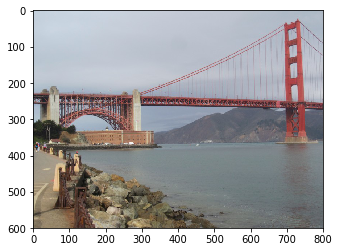

The location of this picture is most likely Golden Gate Bridge, Brooklyn Bridge, or Forth Bridge.


In [132]:
def suggest_locations(img_path):
    # get landmark predictions
    predicted_landmarks = predict_landmarks(img_path, 3)

    ## TODO: display image and display landmark predictions
    img = Image.open(img_path)
    plt.imshow(img)
    plt.show()    
    print('The location of this picture is most likely\
 {}, {}, or {}.'.format(predicted_landmarks[0],predicted_landmarks[1],predicted_landmarks[2]))

    

# test on a sample image
suggest_locations('images/test/09.Golden_Gate_Bridge/190f3bae17c32c37.jpg')

### (IMPLEMENTATION) Test Your Algorithm

Test your algorithm by running the `suggest_locations` function on at least four images on your computer. Feel free to use any images you like.

__Question 4:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ (Three possible points for improvement)

##### I am satisfied with the output:)

> We can add more places like the Great Giza pyramids or other Pharaonic monuments.

> We Can improve the results style transfer between locations.

> We can predict the weather when the photo taken.



 The target place is: Giza pyramids


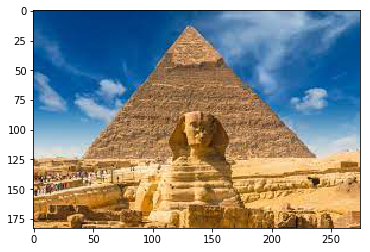

The location of this picture is most likely Temple of Olympian Zeus, Grand Canyon, or Badlands National Park.


 The target place is: Washington Monument


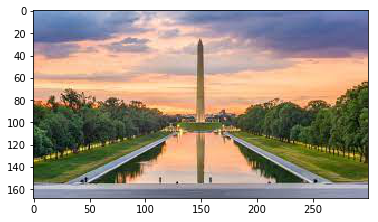

The location of this picture is most likely Washington Monument, Eiffel Tower, or Stockholm City Hall.


 The target place is: Temple of Olympian Zeus


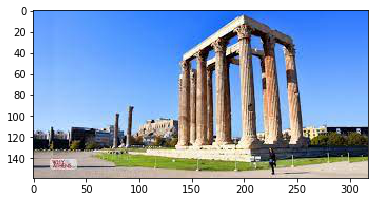

The location of this picture is most likely Temple of Olympian Zeus, Stockholm City Hall, or Brooklyn Bridge.


 The target place is: Hanging Temple


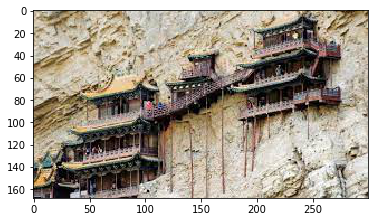

The location of this picture is most likely Hanging Temple, Trevi Fountain, or Prague Astronomical Clock.


In [136]:
## TODO: Execute the `suggest_locations` function on
## at least 4 images on your computer.
## Feel free to use as many code cells as needed.

files = os.listdir('/home/workspace/nd101-c2-landmarks-starter/landmark_project/')
img_files = list(filter(lambda x: '.jpg' in x, files))
for img in img_files:
    print('\n\n The target place is: '+img.split('.')[0])
    suggest_locations(img)